Files ending with `_v2` correspond to model is the almost the exact same as the one Marc has been working with, but with two state variables instead of three (i.e., time is not a state variable. )

# Import Python Preliminaries

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import cloudpickle
from jax.tree_util import Partial

sys.path.append('/Users/jackli/Documents/Research/nndp_local/source_finite')

In [2]:
from core import train, evaluate_policy
from model_v2 import u, v_T, m, F, T, nn_to_action
from model_v2 import alpha, delta, r, beta, rho_z, sigma_z
from policy_function import make_policy_function

# Define and Train Neural Network

In [3]:
%%time
key = jax.random.PRNGKey(0)
params, policy = make_policy_function(nn_to_action = nn_to_action,
                                      key = key,
                                      K = 2,
                                      P = 1,
                                      N_nodes = 256,
                                      N_hidden = 3,
                                      f_activation = jax.nn.tanh,
                                      f_outputs = [jax.nn.relu]
                                      )

params = train(key = key,
               params = params,
               policy = policy,
               u = u,
               v_T = v_T,
               m = m,
               F = F,
               T = T,
               N_simul = 1,
               batch_size = 1024,
               N_iter = 500,
               optimizer = optax.adam(1e-3)
               )
print('')

[4146024105  967050713] [2718843009 1272950319]
Objective value on training iteration 499 out of 500: 18.555027008056648
CPU times: user 2min 4s, sys: 30.1 s, total: 2min 34s
Wall time: 1min 4s


## Save Model

In [4]:
# # Save the policy function
# with open('models/' + str(tag) + '_policy.pkl', 'wb') as f:
#     cloudpickle.dump(policy, f)

# # Save the parameters
# with open('models/' + str(tag) + '_params.pkl', 'wb') as f:
#     cloudpickle.dump(params, f)

## Load Model

In [5]:
# # Load the saved policy function
# with open('models/' + str(tag) + '_policy.pkl', 'rb') as f:
#     policy = cloudpickle.load(f)

# # Load the saved parameters
# with open('models/' + str(tag) + '_params.pkl', 'rb') as f:
#     params = cloudpickle.load(f)

# Plots

## Analytical Solution

In [6]:
def an_policy(s, policy_params=0): 
    z = s[:,0]
    k = s[:,1]
    return (((delta + r) / (alpha * jnp.exp(rho_z*z + 0.5*sigma_z**2))) ** (1 / (alpha - 1))).reshape(-1, 1)

## Plot Policy Function

In [7]:
z = jnp.linspace(-0.4, 0.4)
k = jnp.linspace(0.01, 15)

k_fixed = 10
s_z = jnp.column_stack((z, [k_fixed]*len(k)))

z_fixed = 0
s_k = jnp.column_stack(([z_fixed]*len(z), k))

policy_values_z = policy(s_z, params)
an_policy_values_z = an_policy(s_z)
policy_pct_error_z = [100 * (list(policy_values_z)[i] / list(an_policy_values_z)[i] - 1) for i in range(len(s_z))]

policy_values_k = policy(s_k, params)
an_policy_values_k = an_policy(s_k)
policy_pct_error_k = [100 * (list(policy_values_k)[i] / list(an_policy_values_k)[i] - 1) for i in range(len(s_k))]

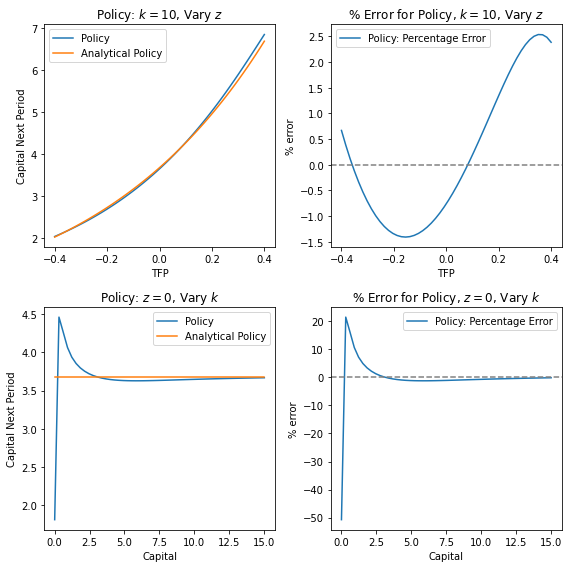

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

#set 1
axs[0][0].plot(z, policy_values_z, label='Policy')
axs[0][0].plot(z, an_policy_values_z, label='Analytical Policy')
axs[0][0].set_title('Policy: $k = 10$, Vary $z$')
axs[0][0].set_xlabel('TFP')
axs[0][0].set_ylabel('Capital Next Period')
axs[0][0].legend()

axs[0][1].plot(z, policy_pct_error_z, label='Policy: Percentage Error')
axs[0][1].set_title('% Error for Policy, $k = 10$, Vary $z$')
axs[0][1].set_xlabel('TFP')
axs[0][1].set_ylabel('% error')
axs[0][1].axhline(y=0, color='gray', linestyle='--')
axs[0][1].legend()

#set 3
axs[1][0].plot(k, policy_values_k, label='Policy')
axs[1][0].plot(k, an_policy_values_k, label='Analytical Policy')
axs[1][0].set_title('Policy: $z = 0$, Vary $k$')
axs[1][0].set_xlabel('Capital')
axs[1][0].set_ylabel('Capital Next Period')
axs[1][0].legend()

axs[1][1].plot(k, policy_pct_error_k, label='Policy: Percentage Error')
axs[1][1].set_title('% Error for Policy, $z = 0$, Vary $k$')
axs[1][1].set_xlabel('Capital')
axs[1][1].set_ylabel('% error')
axs[1][1].axhline(y=0, color='gray', linestyle='--')
axs[1][1].legend()

plt.tight_layout()
# plt.savefig(PATH+'/figures/'+tag)
plt.show()